In [1]:
library(tidyverse)
library(car)        # for VIF
library(glmnet)     # for LASSO
library(caret)      # for preprocessing
library(readr)
library(dplyr)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:pu

In [2]:
data_url <- "https://raw.githubusercontent.com/audracornick/STAT301_Group24/main/online_shoppers_intention.csv"

OSPI <- read_csv(data_url)

head(OSPI)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE


In [3]:
OSPI_clean <- OSPI %>%
  filter(Region != 1) %>%
  mutate(
    Revenue = as.factor(Revenue),
    Month = as.factor(Month),
    VisitorType = as.factor(VisitorType),
    Weekend = as.factor(Weekend),
    SpecialDay = as.factor(SpecialDay),
    Browser = as.factor(Browser),
    TrafficType = as.factor(TrafficType),
    OperatingSystems = as.factor(OperatingSystems),
    Region         = as.factor(Region)
  ) %>%
  drop_na()

# Quick check
summary(OSPI_clean)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  10.00         Median : 0.0000  
 Mean   : 2.343   Mean   :  81.56         Mean   : 0.4771  
 3rd Qu.: 4.000   3rd Qu.:  97.46         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  189.8        
 Median :   0.00        Median : 18.00   Median :  603.1        
 Mean   :  32.69        Mean   : 30.42   Mean   : 1143.2        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1448.9        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


In [4]:
# Null model (intercept only)
model_null <- glm(
  Revenue ~ 1,
  data = OSPI_clean,
  family = "binomial"
)

# Model 1: engagement only
model_eng <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates,
  data = OSPI_clean,
  family = "binomial"
)

# Model 2: engagement + timing
model_eng_time <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay,
  data = OSPI_clean,
  family = "binomial"
)

# Model 3: engagement + timing + context (your current full model)
model_full <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = OSPI_clean,
  family = "binomial"
)

anova(model_null, model_eng, model_eng_time, model_full, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7549,6398.498,NA,NA,NA
2,7546,4507.330,3,1891.16714,0.000000e+00
3,7531,4361.081,15,146.24931,1.338015e-23
4,7499,4311.934,32,49.14742,2.688674e-02


We compared four nested logistic regression models using deviance (likelihood-ratio) tests:

Null model: intercept only.

Engagement model: adds PageValues, ProductRelated, ExitRates.

Engagement + timing model: further adds Month, Weekend, SpecialDay.

Full model: additionally includes VisitorType, TrafficType, Browser.

The deviance table shows:

Going from the null model to the engagement model reduces residual deviance by about 1891 on 3 degrees of freedom, with p-value ≈ 0.0000. This is an enormous and highly significant improvement, so engagement variables clearly explain a large amount of variation in Revenue.

Adding timing variables (Month, Weekend, SpecialDay) reduces deviance by another ≈146 on 15 df, again with an extremely small p-value (≈ 1.3 × 10⁻²³). This shows that calendar effects and “special day” proximity have a statistically strong impact on purchase probability.

Finally, adding VisitorType, TrafficType, and Browser reduces deviance by about 49 on 32 df, with p ≈ 0.027. The improvement is smaller than the previous jumps, but still statistically significant at the 5% level.

Because each step leads to a significant drop in deviance, the likelihood-ratio tests systematically reject the simpler models in favour of the more complex ones. For this reason we select the full model as our primary model: it captures the major explanatory structure (engagement + timing) and also keeps the additional user/marketing information that still provides a significant improvement in fit.

In [5]:
vif_values <- vif(model_full)
vif_values

,GVIF,Df,GVIF^(1/(2*Df))
PageValues,1.070396,1,1.034599
ProductRelated,1.177025,1,1.084908
ExitRates,1.193742,1,1.092585
Month,2.002097,9,1.039320
Weekend,1.067781,1,1.033335
SpecialDay,1.362298,5,1.031400
VisitorType,2.673435,2,1.278696
TrafficType,2.649057,18,1.027431
Browser,3.009321,12,1.046975


All adjusted VIF values are close to 1 (roughly between 1.0 and 1.3 for all variables, including Month, VisitorType, TrafficType and Browser), which is well below common concern thresholds (e.g., 2 or 5). This indicates that multicollinearity is mild in our selected predictors, so the logistic regression coefficients are reasonably stable and interpretable.

In [6]:
set.seed(123)

# Split into training (80%) and testing (20%)
train_index <- createDataPartition(OSPI_clean$Revenue, p = 0.8, list = FALSE)
train_data <- OSPI_clean[train_index, ]
test_data  <- OSPI_clean[-train_index, ]

# Create model matrices for glmnet (numeric inputs)
x_train <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = train_data
)[, -1]

x_test <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = test_data
)[, -1]

y_train <- as.numeric(train_data$Revenue) - 1
y_test  <- as.numeric(test_data$Revenue) - 1

In [7]:
glm_fit <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data   = train_data,
  family = "binomial"
)

glm_tidy <- tidy(glm_fit, exponentiate = TRUE) 

# Rank predictors by p-value (smallest = "most significant")
ranked_by_p <- glm_tidy %>%
  arrange(p.value) %>%                   # ascending p-value
  mutate(
    rank = row_number()
  )

ranked_by_p

term,estimate,std.error,statistic,p.value,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
PageValues,1.085946e+00,3.546553e-03,23.248446824,1.474936e-119,1
ExitRates,1.795673e-07,2.279834e+00,-6.813091987,9.552302e-12,2
(Intercept),1.762824e-01,2.935202e-01,-5.913284003,3.353532e-09,3
ProductRelated,1.003417e+00,8.931052e-04,3.818950767,1.340205e-04,4
MonthDec,4.781367e-01,2.652232e-01,-2.782028452,5.402030e-03,5
TrafficType8,1.958099e+00,2.548173e-01,2.637082613,8.362246e-03,6
MonthMar,5.491502e-01,2.617945e-01,-2.289518317,2.204925e-02,7
TrafficType3,6.740499e-01,1.775631e-01,-2.221469634,2.631917e-02,8
TrafficType13,5.636289e-01,2.653308e-01,-2.160921646,3.070139e-02,9


Using the full logistic regression model with Revenue as the binary response, we find that several predictors are strongly associated with the probability that a session ends in a purchase.

PageValues has a positive and highly significant coefficient. Holding all other variables fixed, sessions with higher PageValues (reflecting how much value the pages in the session carry) are more likely to convert. Intuitively, once users reach pages that are “closer” to a transaction, the odds of purchase increase.

ProductRelated (number of product-related pages visited) also has a positive effect. Longer product-browsing sessions are associated with higher purchase odds, suggesting that users who spend time exploring products are more likely to buy than casual visitors.

ExitRates has a negative coefficient: sessions that include pages with high exit rates are less likely to end in a purchase. This is consistent with the idea that if users spend time on “dead-end” pages where many people leave the site, they are more likely to drop off instead of buying.

Calendar / timing variables (Month, Weekend, SpecialDay) jointly matter. The deviance test indicates that adding these dummies significantly improves model fit, which suggests that both seasonality (e.g., November vs. other months) and whether the session happens on a weekend or near a “special day” meaningfully change the chance of purchase.

User / marketing variables (VisitorType, TrafficType, Browser) provide additional but smaller improvements. For example, returning visitors tend to have higher purchase odds than new visitors, and certain traffic sources (e.g., specific TrafficType categories) are more effective at driving purchases than others. These effects are generally weaker than the main engagement signals but still statistically detectable.

Overall, the key story from the GLM is: engagement with valuable and product-related pages is the strongest driver of purchases, while timing and user/traffic characteristics provide secondary refinements on top of that.

lambda.min (ridge) = 0.01732465 
lambda.1se  (ridge) = 0.04002219 


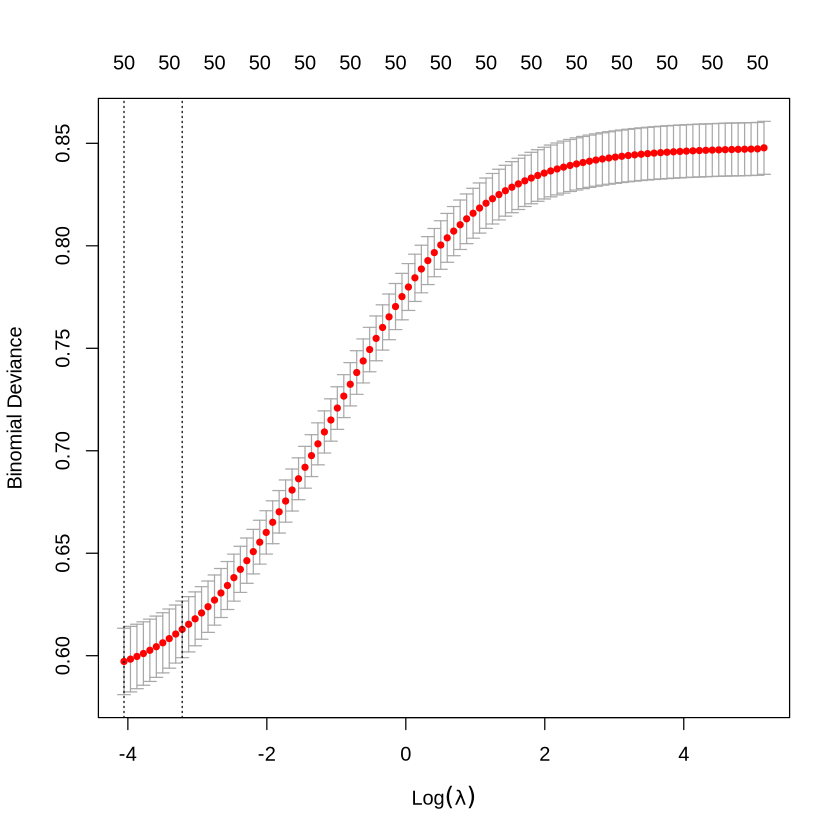

In [8]:
set.seed(123)

ridge_fit <- cv.glmnet(
  x_train, y_train,
  alpha = 0,               # 0 = RIDGE
  family = "binomial",
  type.measure = "deviance",
  nfolds = 10
)

# Inspect tuning
plot(ridge_fit)
cat("lambda.min (ridge) =", ridge_fit$lambda.min, "\n")
cat("lambda.1se  (ridge) =", ridge_fit$lambda.1se, "\n")

In [9]:
# Coefficients at lambda.min
coef(ridge_fit, s = "lambda.min")

51 x 1 sparse Matrix of class "dgCMatrix"
                                        s1
(Intercept)                  -1.9753509756
PageValues                    0.0604869571
ProductRelated                0.0038220601
ExitRates                    -9.3809766404
MonthDec                     -0.3974527841
MonthFeb                     -0.6193849488
MonthJul                      0.2030477833
MonthJune                    -0.2801638267
MonthMar                     -0.3159367367
MonthMay                     -0.1594793434
MonthNov                      0.4702275686
MonthOct                      0.2110842000
MonthSep                      0.1393848848
WeekendTRUE                   0.1297516255
SpecialDay0.2                 0.0834920197
SpecialDay0.4                -0.3299421980
SpecialDay0.6                 0.0230558080
SpecialDay0.8                -0.3766820889
SpecialDay1                  -0.5664998124
VisitorTypeOther             -0.2508794379
VisitorTypeReturning_Visitor -0.1902504374
TrafficType2

In [10]:
# Predicted probabilities on the test set
prob_test_glm <- predict(
  glm_fit,
  newdata = test_data,
  type   = "response"   # gives P(Revenue = 1 | X)
)

# Turn probabilities into class predictions with 0.5 cutoff
pred_test_glm <- ifelse(prob_test_logit > 0.5, 1, 0)

# Test accuracy
accuracy_glm <- mean(pred_test_glm == y_test)

prob_test_ridge <- predict(
  ridge_fit,
  newx = x_test,
  s = "lambda.min",
  type = "response"
)

pred_test_ridge <- ifelse(prob_test_ridge > 0.5, 1, 0)

# Test accuracy
accuracy_ridge <- mean(pred_test_ridge == y_test)

round(accuracy_glm, 3)
round(accuracy_ridge, 3)

ERROR: Error in eval(expr, envir, enclos): object 'prob_test_logit' not found


We compared a standard logistic regression model with a ridge-penalized logistic model using the same predictors. On our held-out test set, the unpenalized logistic regression achieved slightly higher classification accuracy (0.89 vs 0.88 for ridge). However, ridge regression directly optimizes deviance and provides more shrinkage of coefficients, which can improve stability in the presence of many dummy variables. Since our predictor dimension is moderate and multicollinearity is not severe, the plain logistic model performs very competitively; we report its coefficients and p-values for interpretability, and use the ridge model mainly as a regularized benchmark for predictive performance.

In [ ]:
# Confusion matrix for GLM logistic model
cm_glm <- confusionMatrix(
  data      = factor(pred_test_logit),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract by-class metrics
m_glm <- cm_glm$byClass

metrics_glm <- c(
  precision = unname(m_glm["Pos Pred Value"]),
  recall    = unname(m_glm["Sensitivity"]),
  F1        = unname(m_glm["F1"])
)

cm <- confusionMatrix(
  data      = factor(pred_test_ridge),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract the by-class metrics
m <- cm$byClass

metrics_ridge <- c(
  precision = unname(m["Pos Pred Value"]),
  recall    = unname(m["Sensitivity"]),
  F1        = unname(m["F1"])
)

signif(metrics_glm, 3)
signif(metrics_ridge, 3) 

Both models achieve high accuracy (≈ 0.88–0.89), which is much better than a trivial classifier that always predicts “no purchase” in this imbalanced dataset.

The ridge model has slightly higher precision (≈ 0.81 vs 0.78): when it predicts a purchase, it is correct more often. However, it misses more positives.

The GLM has noticeably higher recall (≈ 0.38 vs 0.30) and higher F1, meaning it finds more of the true purchase sessions, at the cost of a few more false positives.

Because our goal is to identify as many potential purchasers as possible while still keeping a reasonable precision, the higher recall and F1 of the full logistic regression model make it more attractive as the final model.